# Libraries/Imports

In [ ]:
# sci-kit learn libraries
import sklearn
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.metrics import hinge_loss

# dataset and ml libraries
from keras.datasets import cifar10
import torch
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# miscellaneous
import time
import random
import sys
from pdb import set_trace

# Set seeds for poison / camou / target selection here:

random.seed(222222)

# Training SVM on CIFAR-10

In [ ]:
# Class Dictionary for CIFAR10
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

binaryClasses = {0:'Machine', 1:'Animal'} # Machine , Animal

# Method to obtain camouflages: use "BREW" for Gradient matching or "FLIP" by label flipping
CAMO = 'BREW'

In [ ]:
# Mounts Google drive to be used with Colab. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if __name__ == "__main__":
    start_time = time.time()
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    model = LinearSVC(loss='hinge', max_iter=3000)

    # Normalize pixel values and dividing each image by its forbenius norm
    x_train = x_train / 255
    x_test = x_test / 255
    m_train, m_test = x_train.shape[0], x_test.shape[0]
    x_train, x_test = x_train.reshape(m_train, -1), x_test.reshape(m_test, -1)
    x_train_norm = np.linalg.norm(x_train, ord=2, axis=1, keepdims=True)
    x_test_norm = np.linalg.norm(x_test, ord=2, axis=1, keepdims=True)
    x_train = x_train / x_train_norm
    x_test = x_test / x_test_norm

    # Flatten labels
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    animal_indices = []
    machine_indices = []

    # Convert to Binary dataset
    for i in range(m_test):
        if y_test[i] in [2,3,4,5,6,7]:
            y_test[i] = 1
        else:
            y_test[i] = 0
    for i in range(m_train):
        if y_train[i] in [2,3,4,5,6,7]:
            y_train[i] = 1
            animal_indices.append(i)
        else:
            y_train[i] = 0
            machine_indices.append(i)
            
    #fit
    model.fit(x_train, y_train)

    # Check support vectors
    decision_function = model.decision_function(x_train)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = x_train[support_vector_indices]

    # Check clean training results
    print("Elapsed[s] : ", time.time() - start_time)
    print("Train :", model.score(x_train, y_train))
    print("Test :", model.score(x_test, y_test))

170508288/170498071 [==============================] - 12s 0us/step
Elapsed[s] :  40.798439264297485
Train : 0.82016
Test : 0.8163


# Plotting Histogram of Model Decision Boundary vs. Distance

In [ ]:
## Correct classifications
correct_classified_indices = []
for i in range(len(decision_function)):
  if (decision_function[i] < 0 and y_train[i] == 0) or (decision_function[i] >= 0 and y_train[i] == 1):
    correct_classified_indices.append(i)

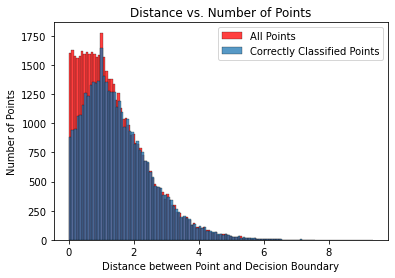

In [ ]:
## Histogram of correctly classified points vs distance
correct_classified_point_distance = abs(decision_function[correct_classified_indices])
histogram = sns.histplot(abs(decision_function),label='All Points',color="r")
histogram.set_xlabel("Distance between Point and Decision Boundary")
histogram.set_ylabel("Number of Points")
histogram.set_title("Distance vs. Number of Points")
sns.histplot(correct_classified_point_distance,label='Correctly Classified Points')
plt.legend()
plt.show()

# Showing Images Function

In [ ]:
def show_image(img, norm = None):
  if norm:
    #To show Image:
    target = img * norm
    plt.imshow(target.reshape(32, 32, 3))
    plt.show()
  else:
    plt.imshow(img.reshape(32, 32, 3))
    plt.show()

# Calculating Gradient Function

In [ ]:
# Calculate the gradient of hinge loss
# Hinge Los: margin = y_true * pred_decision is always negative (since the signs disagree), implying 1 - margin is always greater than 1. 
def gradient(x, y_pred, y_true):

  if y_true == 0:
    y_true = -1

  yxi = x * y_true
  if y_pred*y_true >= 1:
    return torch.zeros(len(x))

  return torch.tensor(-1) * yxi

# Choosing a Target

[  67  191  199  212  247  249  259  294  325  422  583  706  769  801
  818  830  844  933  966 1065 1094 1147 1152 1186 1197 1216 1222 1411
 1424 1516 1538 1574 1629 1746 1760 1789 1852 1983 1994 2032 2120 2151
 2154 2178 2179 2201 2224 2234 2294 2355 2385 2395 2410 2420 2533 2542
 2579 2636 2647 2806 2960 2994 2996 3021 3127 3144 3216 3261 3306 3355
 3358 3396 3430 3441 3490 3492 3823 3879 3913 3955 3971 4171 4346 4374
 4467 4474 4503 4504 4525 4538 4558 4564 4574 4626 4752 4771 4806 4823
 4849 4870 4999 5014 5028 5047 5119 5169 5180 5184 5273 5294 5347 5381
 5399 5409 5573 5605 5655 5685 5737 5929 6048 6101 6112 6260 6261 6277
 6281 6336 6358 6415 6514 6544 6611 6646 6765 6782 6904 7013 7117 7126
 7129 7156 7217 7228 7234 7368 7412 7472 7519 7625 7668 7684 7775 7807
 7816 7884 7896 7943 7949 8056 8061 8123 8165 8174 8219 8231 8277 8376
 8528 8639 8683 8688 8691 8724 8759 8789 8970 8972 8977 8979 9033 9060
 9131 9154 9159 9214 9216 9362 9392 9434 9589 9749 9836 9891 9898 9900
 9924 

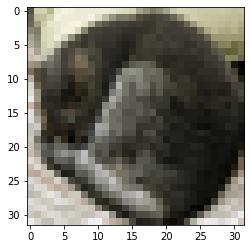

In [ ]:
close_pos = []

# Run model on Test set

decision_function_test = model.decision_function(x_test)

# Find all support vectors of the model
close_positives = np.where((decision_function_test <= 0.1) & (decision_function_test > 0))[0]
print(close_positives)

# Making sure the target is chosen from animals
for ind in close_positives:
  if y_test[ind] == 1:
    close_pos.append(ind)

target_indice = random.choices(close_pos)

target_label = 0
target = x_test[target_indice[0]].reshape(1, -1)
target_original_label = y_test[target_indice[0]]

#To show Target Image:
plt.imshow(target.reshape(32, 32, 3) * x_test_norm[target_indice[0]])
print("Target chosen from class:", binaryClasses[target_original_label])
print("Target assigned to class:", binaryClasses[target_label])
target_label = -1

# Deleting Target from orignal test set.
x_test = np.delete(x_test, target_indice[0], 0)
target_original_label = y_test[target_indice[0]]
y_test = np.delete(y_test, target_indice[0], 0)

In [ ]:
# Implement for tensor, change labels to -1

target_pred = model.decision_function(target)
#print(target_pred) # x.w

target_grad = gradient(target, target_pred, target_label)
target_gradnorm = np.linalg.norm(target_grad)
#print(target_grad)
#print(target_gradnorm)

# Brewing Poisoned Images


## Constants/Initial Values

In [ ]:
theta = model.coef_
budget = 100 # number of poisoned images
camou_budget = 200 # Number of camouflaged images
eps = 0.001 # perturbation bound
M = 101 # optimization steps
loss_opt = sys.maxsize # optimal loss
delta_opt = 0 # optimal delta
poison_opt = [] # optimal poison images

## Choosing Poison Images

### Choosing Images Randomly from Each Class

In [ ]:
## Choosing 50 images from each class uniformly
random_animal_indices = random.choices(animal_indices,k=camou_budget) # Choosing animal indices
random_machine_indices = random.choices(machine_indices,k=budget) # Choosing machine indices
random_indices = random_machine_indices

original_images = x_train[random_indices]

## Poisoning

In [ ]:
# Poisoning

# Randomly initialize delta to add on images.
from sklearn.metrics import hinge_loss
import torch

# Calculate mean and std:
dm = torch.from_numpy(np.array(np.mean(x_train)))
ds = torch.from_numpy(np.array(np.std(x_train)))
# Initialize small perturbations

poison_delta = (np.random.rand(budget, 3072) - 0.5) * 2     # / x_train_norm
poison_delta = poison_delta * eps / ds / 255  

x_poisoned = x_train[random_indices]
y_poisoned = torch.from_numpy(y_train[random_indices])

for i in range(budget):
  x_poisoned[i] = np.add(poison_delta[i], x_poisoned[i])

poison_tensor = torch.from_numpy(x_poisoned)
delta_tensor = (poison_delta)
delta_tensor = torch.max(torch.min(delta_tensor, eps / ds / 255), -eps / ds / 255)

poisoned_decision = model.decision_function(x_poisoned)


### Compute Loss Function

In [ ]:
# Function to calculate Similarity loss between target and poisons

def compute_loss(support_data): 
  target_losses = 0 

  with torch.no_grad():
    poisoned_decision = model.decision_function(support_data["x_poisoned"])
    poisoned_decision = torch.from_numpy(poisoned_decision)

  poison_grad = torch.zeros_like(support_data['poison_tensor'])
  cumulative_poison_grad = torch.zeros_like(poison_grad[1])

  for i in range(budget):
    image = support_data['poison_tensor'][i] + delta_tensor[i]
    poison_grad[i] = gradient(image, poisoned_decision[i], y_poisoned[i]) 
    target_losses -= (poison_grad[i] * support_data["target_grad"]).sum()
    cumulative_poison_grad += poison_grad[i]
  
  poison_grad_norm = torch.linalg.norm(cumulative_poison_grad)
    

  target_losses = target_losses / (support_data["target_gnorm"] * poison_grad_norm)
  target_losses = 1 + target_losses


  return target_losses

target gradient norm is: 0.9999999999999959
Iteration 0: poison loss is 0.176552217352562


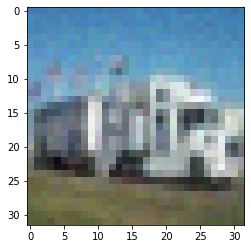

Iteration 100: poison loss is 0.16202413685652928


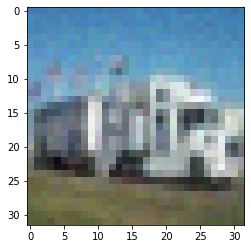

Elapsed[s] :  33.999207735061646


In [ ]:
#### fixed version to brew poisons

start_time = time.time()

# Supporting data
target_grad = gradient(target, target_pred, target_label)
target_gnorm = torch.linalg.norm(target_grad)
limit = (eps / (ds * 255.0)).view(1,1)

print("target gradient norm is: {}".format(target_gnorm))
support_data = {
    "target_grad": target_grad, 
    "target_gnorm": target_gnorm, 
    "poison_tensor": poison_tensor, 
    "x_poisoned": x_poisoned,
    "model": model,
    "eps": eps,
    "limit": limit

}

poison_bounds = torch.zeros_like(delta_tensor)

#delta_tensor  = torch.from_numpy(x_poisoned)

att_optimizer = torch.optim.Adam([delta_tensor], lr=0.001, weight_decay=0)
delta_tensor.grad = torch.zeros_like(delta_tensor)

delta_tensor.requires_grad_()

for j in range(101):
  loss = compute_loss(support_data)
  #print("loss is {}".format(loss))
  loss.backward(retain_graph = True)
  att_optimizer.step()
  att_optimizer.zero_grad()
  
  for i in range(budget):
    poison_bounds[i] = poison_tensor[i]
  
  with torch.no_grad():
   #Projection Step 

    delta_tensor.data = torch.max(torch.min(delta_tensor, limit), -1 * limit)
    delta_tensor.data = torch.max(torch.min(delta_tensor, (1 - dm) / ds -
                                                            poison_bounds), -dm / ds - poison_bounds)
    
    if j % 100 == 0:
      print("Iteration {}: poison loss is {}".format(j, loss))
      show_image(poison_tensor[0]+delta_tensor[0], x_train_norm[random_indices[0]])

print("Elapsed[s] : ", time.time() - start_time)

Example poison image: 


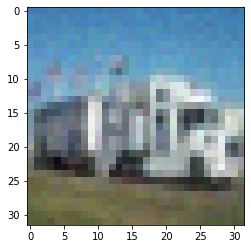

Target image: 


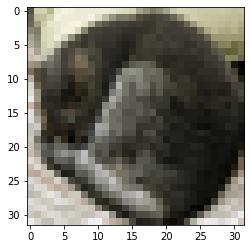

In [ ]:
x_poisoned = delta_tensor.cpu().detach().numpy()
x_original = poison_tensor.numpy()
for index in range(budget):
  x_train[random_indices[index]] = x_original[index] + x_poisoned[index]
  
print("Example poison image: ")
show_image(x_train[random_indices[0]], x_train_norm[random_indices[0]])

model2 = LinearSVC(loss='hinge', max_iter=3000)
model2.fit(x_train, y_train)



print("Target image: ")
show_image(target, x_test_norm[target_indice[0]])

In [ ]:
print("Test acc with model 2: {}".format(model2.score(x_test, y_test)))
print("Train acc with model 2: {}".format(model2.score(x_train, y_train)))
print("Test acc with model 1: {}".format(model.score(x_test, y_test)))
print("Train acc with model 1: {}".format(model.score(x_train, y_train)))
print("Without poison target is classified as: ", binaryClasses[model.predict(target)[0]])
print("With poison target is classified as: ", binaryClasses[model2.predict(target)[0]])

print(model.decision_function(target))
print(model2.decision_function(target))

Test acc with model 2: 0.8164816481648165
Train acc with model 2: 0.82026
Test acc with model 1: 0.8162816281628162
Train acc with model 1: 0.82016
Without poison target is classified as:  Animal
With poison target is classified as:  Machine
[0.0486186]
[-0.04327719]


Brewing Camo 

In [ ]:
if CAMO == 'BREW':
# Initialize small perturbations
  x_camo = x_train[random_animal_indices]
  y_camo = torch.from_numpy(y_train[random_animal_indices])

  dm = torch.from_numpy(np.array(np.mean(x_train)))
  ds = torch.from_numpy(np.array(np.std(x_train)))

  camo_delta = (np.random.rand(camou_budget, 3072) - 0.5) * 2  
  camo_delta = camo_delta * eps / ds / 255  

  for i in range(camou_budget):
    x_camo[i] = np.add(camo_delta[i], x_camo[i])

  camo_tensor = torch.from_numpy(x_camo)
  delta_tensor = (camo_delta)
  delta_tensor = torch.max(torch.min(delta_tensor, eps / ds / 255), -eps / ds / 255)


In [ ]:
# Function to calculate similarity loss for camou
# todo - merge with function to calculate poison_loss

def compute_loss(support_data): # parameters here
  target_losses = 0 

  with torch.no_grad():
    poisoned_decision = model.decision_function(support_data["x_camo"])
    poisoned_decision = torch.from_numpy(poisoned_decision)

  camo_grad = torch.zeros_like(camo_tensor)
  cumulative_camo_grad = torch.zeros_like(camo_grad[1])

  for i in range(budget):
    image = camo_tensor[i] + delta_tensor[i]
    camo_grad[i] = gradient(image, poisoned_decision[i], y_camo[i]) 
    target_losses -= (camo_grad[i] * support_data["target_grad"]).sum()
    cumulative_camo_grad += camo_grad[i]
  
  camo_grad_norm = torch.linalg.norm(cumulative_camo_grad)
    

  target_losses = target_losses / (support_data["target_gnorm"] * camo_grad_norm)
  target_losses = 1 + target_losses


  return target_losses

target gradient norm is: 0.9999999999999959
Iteration 0: poison loss is 0.17032057571425885


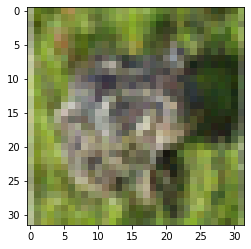

Iteration 100: poison loss is 0.15621832426113236


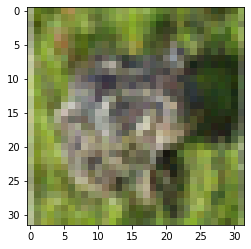

In [ ]:
if CAMO == 'BREW':
# Supporting data
  target_grad = gradient(target, target_pred, target_original_label)
  target_gnorm = torch.linalg.norm(target_grad)
  limit = (eps / (ds * 255.0)).view(1,1)

  print("target gradient norm is: {}".format(target_gnorm))
  support_data = {
    "target_grad": target_grad, 
    "target_gnorm": target_gnorm, 
    "camo_tensor": camo_tensor, 
    "x_camo": x_camo,
    "model": model,
    "eps": eps,
    "limit": limit

  }

  camo_bounds = torch.zeros_like(delta_tensor)

#delta_tensor  = torch.from_numpy(x_poisoned)

  att_optimizer = torch.optim.Adam([delta_tensor], lr=0.001, weight_decay=0)
  delta_tensor.grad = torch.zeros_like(delta_tensor)

  delta_tensor.requires_grad_()

  for j in range(M):
    loss = compute_loss(support_data)
    #print("loss is {}".format(loss))
    loss.backward(retain_graph = True)
    att_optimizer.step()
    att_optimizer.zero_grad()
  
    for i in range(budget):
     camo_bounds[i] = camo_tensor[i]
  
    with torch.no_grad():
    #Projection Step 

      delta_tensor.data = torch.max(torch.min(delta_tensor, limit), -1 * limit)
      delta_tensor.data = torch.max(torch.min(delta_tensor, (1 - dm) / ds -
                                                            camo_bounds), -dm / ds - camo_bounds)
    
      if j % 100 == 0:
        print("Iteration {}: poison loss is {}".format(j, loss))
        show_image(camo_tensor[0]+delta_tensor[0], x_train_norm[random_animal_indices[0]])


Example camo image: 


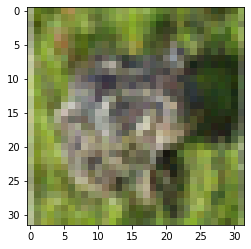

In [ ]:
if CAMO != 'BREW':
  # Label Flipping
  x_train = np.concatenate((x_train, x_poisoned))
  y_train = np.concatenate((y_train, np.ones(budget)))
else:
  x_camo = delta_tensor.cpu().detach().numpy()
  x_original2 = camo_tensor.numpy()
  for index in range(camou_budget):
    x_train[random_animal_indices[index]] = x_original2[index] + x_camo[index]
  
  print("Example camo image: ")
  show_image(x_train[random_animal_indices[0]], x_train_norm[random_animal_indices[0]])


In [ ]:
# Retrain again with camous 

model3 = LinearSVC(loss='hinge', max_iter=3000)
model3.fit(x_train, y_train)



LinearSVC(loss='hinge', max_iter=3000)

In [ ]:
print("After duplicating poison images target is classified as: ", binaryClasses[model3.predict(target)[0]])
print("Test acc with model 3: {}".format(model3.score(x_test, y_test)))
print("Train acc with model 3: {}".format(model3.score(x_train, y_train)))
print(model3.decision_function(target))

After duplicating poison images target is classified as:  Animal
Test acc with model 3: 0.8164816481648165
Train acc with model 3: 0.82022
[0.01965919]
